In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("data/E-commerce.csv")

In [2]:
df.head(10)

,ID,n_clicks,n_visits,amount_spent,amount_discount,days_since_registration,profile_information
0,2085,643,142,300.000000,228.432503,132,411
1,742,527,95,743.832508,60.882831,86,184
2,750,367,49,305.668886,72.961801,334,329
3,1224,466,30,291.191193,101.903170,131,148
4,2210,715,169,703.136878,506.416735,114,160
5,1632,204,84,312.331152,59.930122,274,295
6,2416,600,135,1008.169771,717.696496,165,28
7,903,316,115,823.874562,6.360026,184,146
8,111,224,115,800.000000,24.414520,324,0
9,1581,363,132,322.490806,67.122764,248,101


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2500 non-null   int64  
 1   n_clicks                 2500 non-null   int64  
 2   n_visits                 2500 non-null   int64  
 3   amount_spent             2500 non-null   float64
 4   amount_discount          2500 non-null   float64
 5   days_since_registration  2500 non-null   int64  
 6   profile_information      2500 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 136.8 KB


---
# Placeholder for data explanation
---

We will first visualize the data and try to gain more insight into what we are working with.

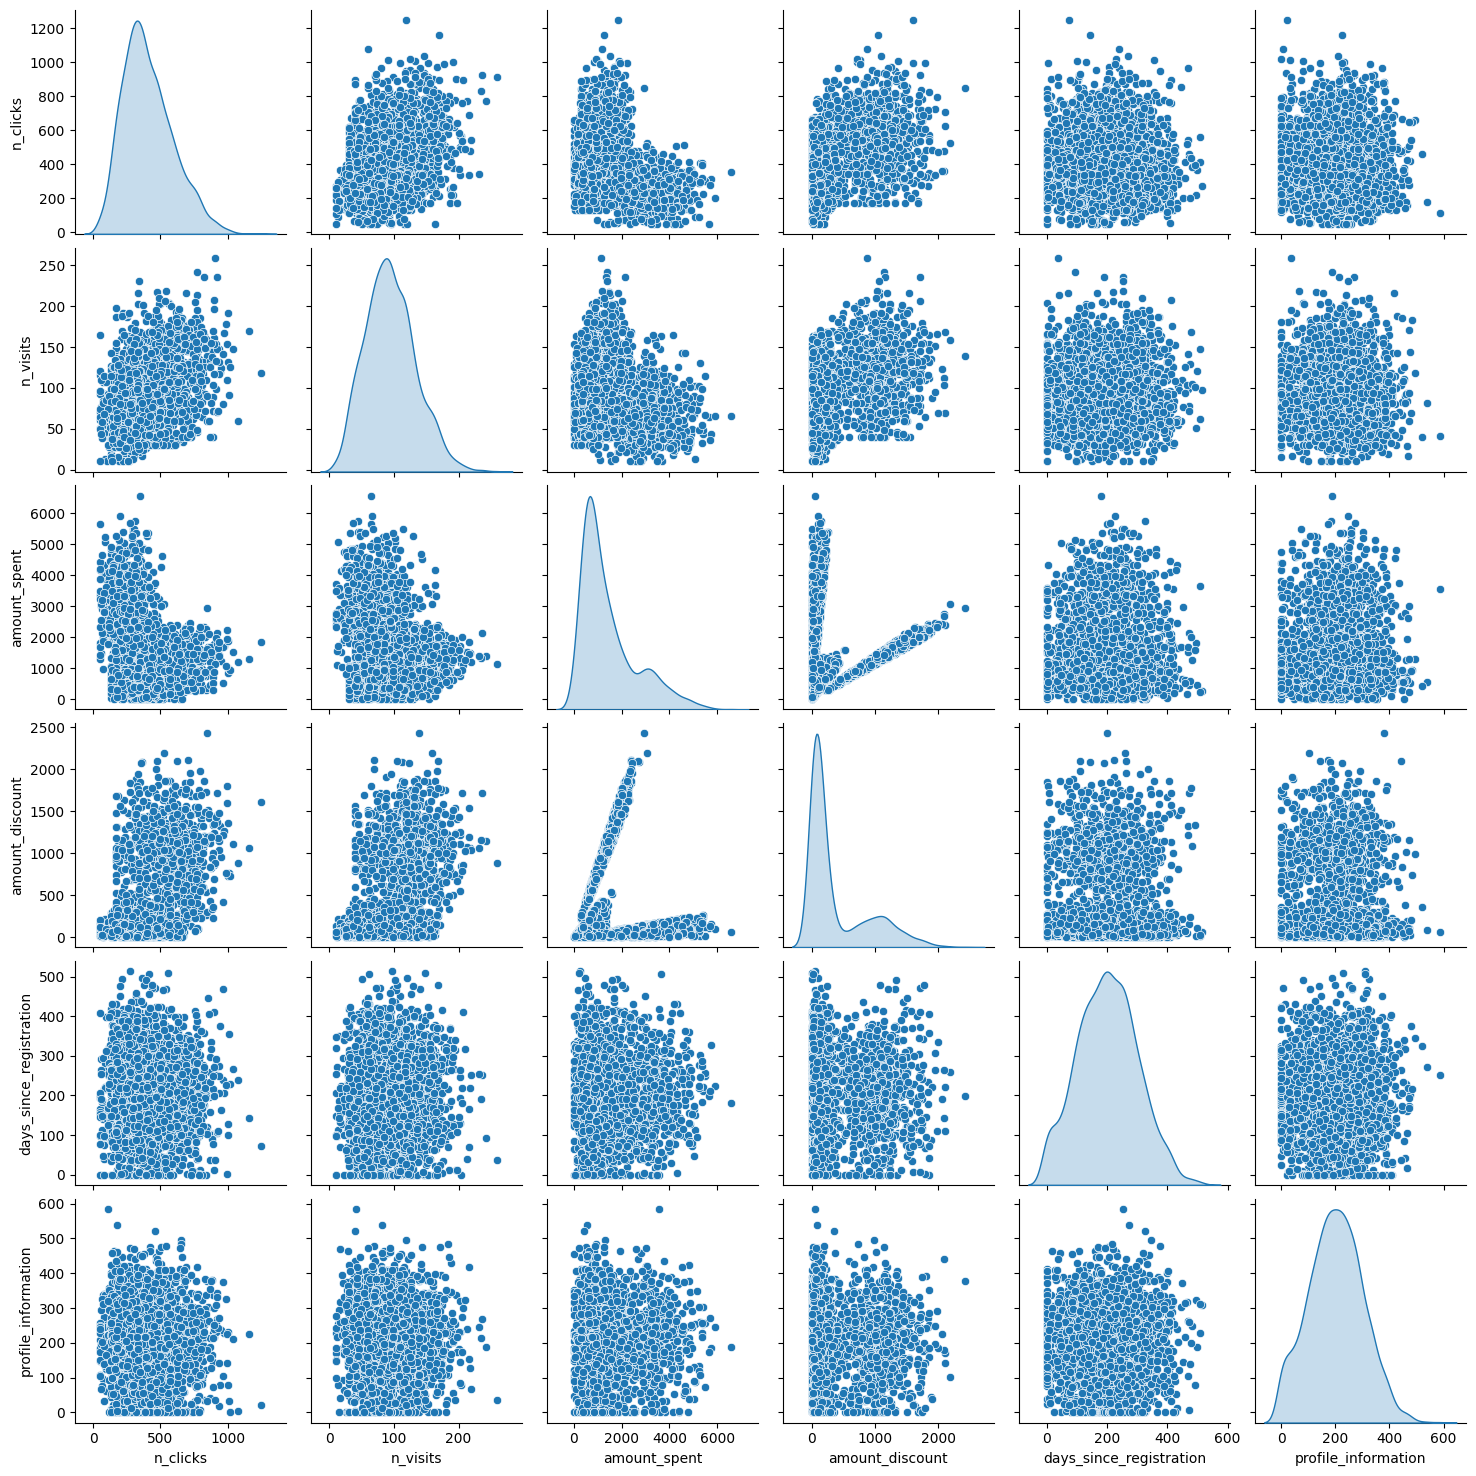

In [5]:
sns.pairplot(df.drop(columns=['ID'], axis=1), diag_kind='kde')

At first glance, we can see most attributes follow a normal distribution, except for "amount_spent" and "amount_discount". We will seperate them into a jointplot for analysis.

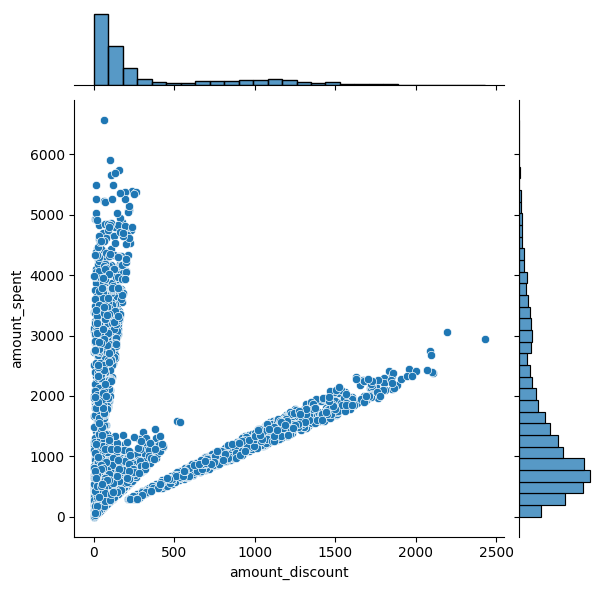

In [7]:
sns.jointplot(y=df['amount_spent'], x=df['amount_discount'])

Looking at the visualization, we can conclude that:
- **amount_spent** has a bell shape with long right tail, which does make sense if sale amount of luxury, expensive products is lower
- Due to the nature of the attributes, **amount_discount** has a mode of 0, and see steep decline at value above 300
- **amount_discount** positively correlate with **amount_spent**, but this correlation is by designed as **amount_discount** is calculated directly using **amount_spent**.

## Implementing Clustering
To make things simple, we first implement clustering based only 2 axis: "n_clicks", and "amount_spent". We don't choose "amount_discount" because as mentioned before, this feature is a product calculated from "amount_spent".



<AxesSubplot:xlabel='amount_spent', ylabel='n_clicks'>

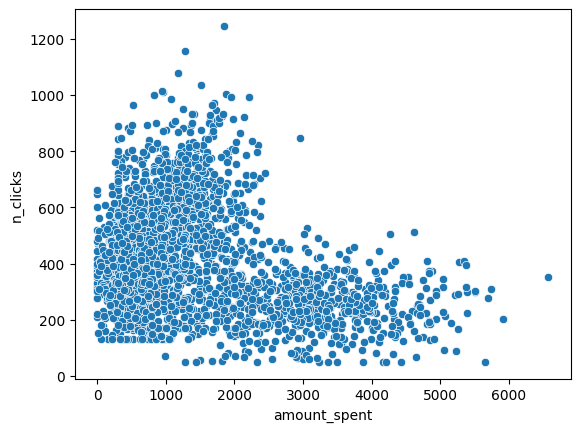

In [15]:
sns.scatterplot(x=df['amount_spent'],y=df['n_clicks'])

If we use just our human eyes, we can clearly see 2 seperate groups derived from the scatter plot. One with high spending amount but low clicks, and high amount of clicks but low spending amount